# HW 1 — ML Pipeline on a Tabular Dataset

**Goal:** practice a full ML workflow — from loading data to evaluating models.

**Dataset:** `scikit-learn/adult-census-income` from Hugging Face.

**Task:** binary classification — predict whether a person earns more than 50K per year.

> Цель — построить полный пайплайн ML: загрузка → EDA → предобработка → обучение → эксперименты → выводы.

## Step 0. Imports
> Импортируем все необходимые библиотеки.

In [ ]:
# Основные библиотеки для данных и визуализации
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасетов с Hugging Face
from datasets import load_dataset

# ML: разбиение, масштабирование, модели, метрики
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("All imports successful!")

## Step 1. Load the Dataset
> Загружаем датасет Adult Census Income с Hugging Face и конвертируем в pandas DataFrame.

In [ ]:
# Загружаем датасет с Hugging Face
ds = load_dataset("scikit-learn/adult-census-income")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income'],
        num_rows: 32561
    })
})


In [ ]:
# Конвертируем в pandas DataFrame для удобной работы
df = ds["train"].to_pandas()
print(f"Shape: {df.shape}")
df.head()

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Step 2. Exploratory Data Analysis (EDA)
> Разведочный анализ: типы данных, пропуски, распределения признаков, корреляции.

In [ ]:
# Типы данных и количество non-null значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
# Описательная статистика числовых признаков
df.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
# Проверяем наличие пропусков
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

Missing values per column:
No missing values!


Target column: 'income'
income
<=50K    24720
>50K      7841
Name: count, dtype: int64


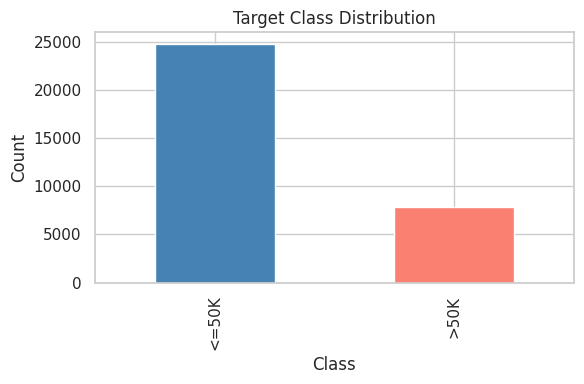

In [ ]:
# Распределение целевой переменной (дисбаланс классов?)
target_col = "income"  # целевая: <=50K или >50K
print(f"Target column: '{target_col}'")
print(df[target_col].value_counts())

fig, ax = plt.subplots(figsize=(6, 4))
df[target_col].value_counts().plot(kind="bar", ax=ax, color=["steelblue", "salmon"])
ax.set_title("Target Class Distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

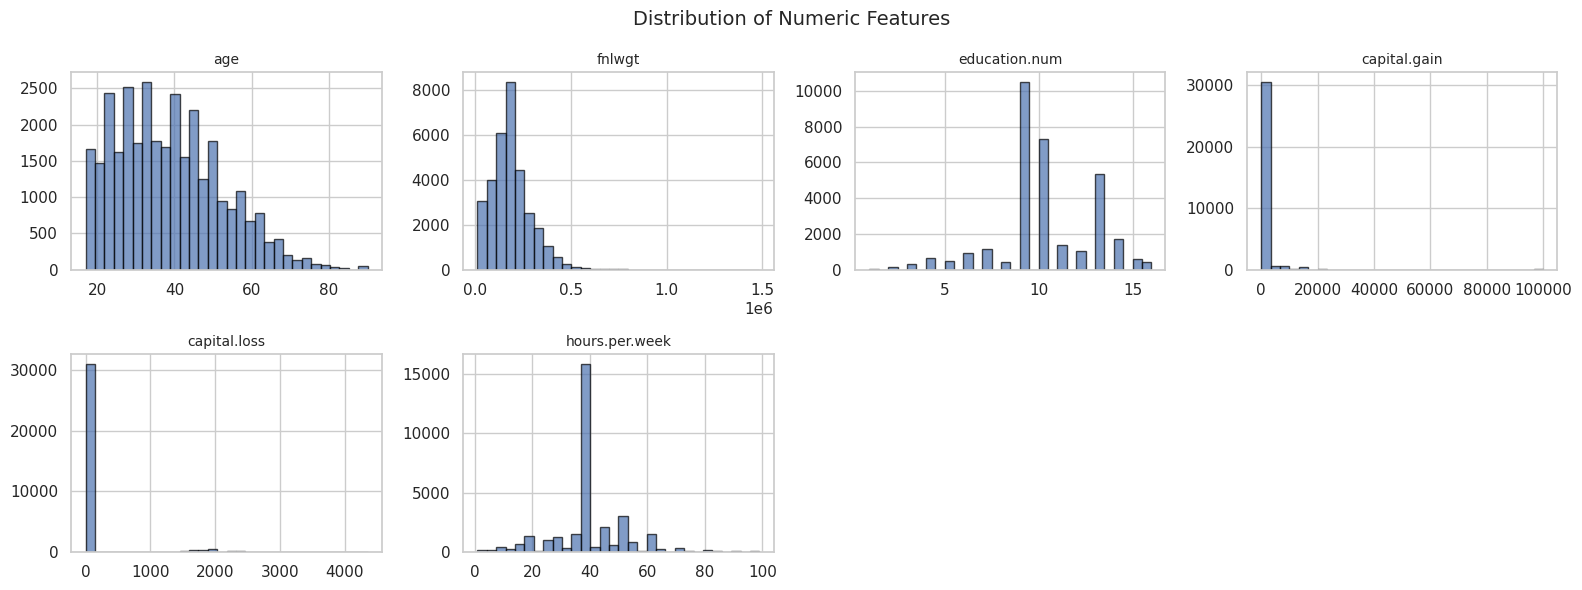

In [ ]:
# Гистограммы числовых признаков — смотрим на распределения и скосы
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)

n = len(numeric_cols)
ncols = 4
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3 * nrows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].hist(bins=30, ax=axes[i], edgecolor="black", alpha=0.7)
    axes[i].set_title(col, fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Distribution of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()

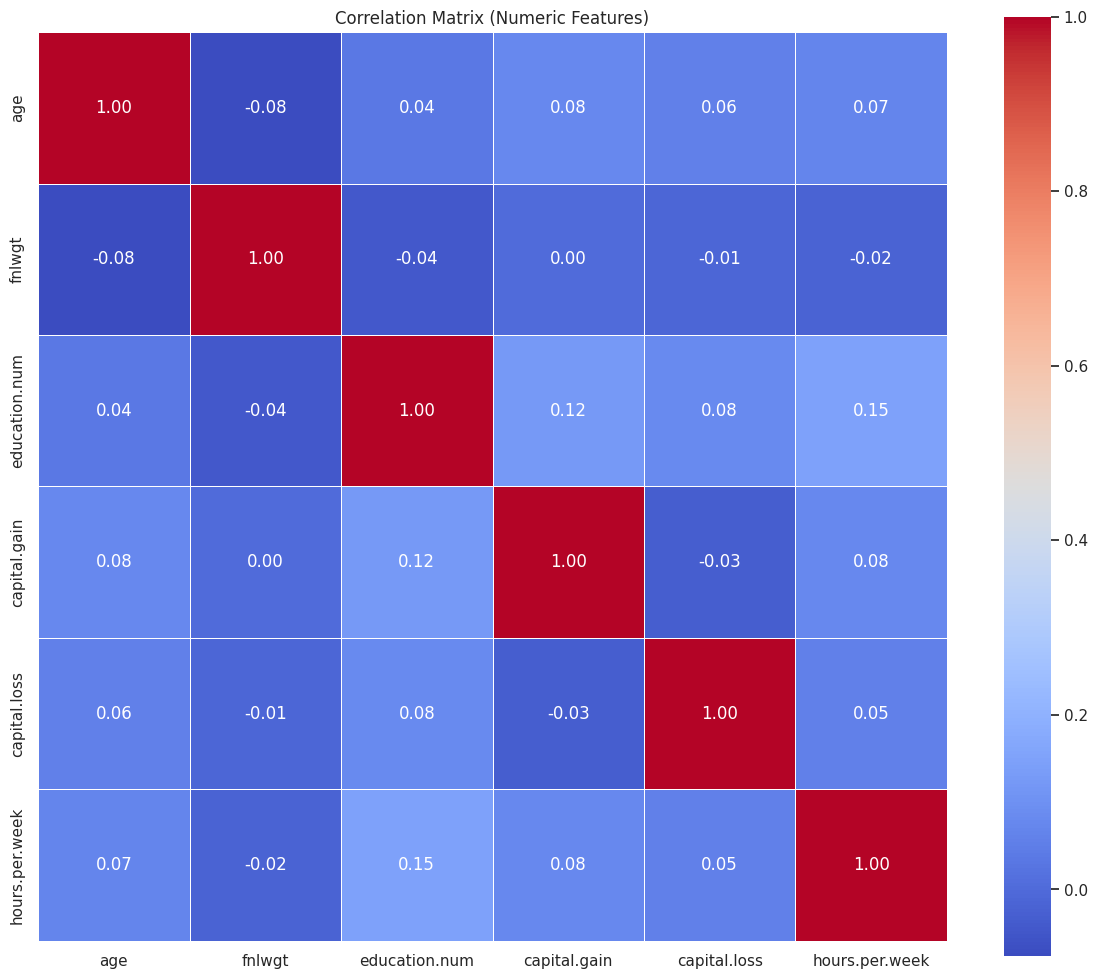

In [ ]:
# Корреляционная матрица — проверяем линейные связи между признаками
fig, ax = plt.subplots(figsize=(12, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", ax=ax, square=True, linewidths=0.5)
ax.set_title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

## Step 3. Data Preprocessing
> Предобработка: кодирование целевой переменной и категорий, разбиение на train/test, масштабирование.

In [ ]:
# Разделяем на признаки (X) и целевую переменную (y)
X = df.drop(columns=[target_col]).copy()
y_raw = df[target_col]

# Кодируем целевую: >50K → 1, <=50K → 0
target_le = LabelEncoder()
y = target_le.fit_transform(y_raw)

print(f"Target mapping: {dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))}")
print(f"Target classes:  {sorted(set(y))}")
print(f"Target shape:   {y.shape}")
print(f"Features shape: {X.shape}")

Target mapping: {'<=50K': np.int64(0), '>50K': np.int64(1)}
Target classes:  [np.int64(0), np.int64(1)]
Target shape:   (32561,)
Features shape: (32561, 14)


In [ ]:
# Кодируем категориальные столбцы через LabelEncoder
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Categorical columns: {cat_cols}")

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Заполняем пропуски медианой (если есть)
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("Missing values imputed with median.")
else:
    print("No missing values to impute.")

Categorical columns: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
No missing values to impute.


In [ ]:
# Разбиение 80/20 со стратификацией (сохраняем пропорции классов)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size:  {X_test.shape[0]}")

Train size: 26048
Test size:  6513


In [ ]:
# Масштабирование: fit на train, transform на обоих (без утечки данных)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete.")

Scaling complete.


## Step 4. Model Training
> Обучаем две модели: Logistic Regression и Random Forest. Сравниваем по Accuracy и F1-macro.

### 4.1 Logistic Regression
> Линейная модель - как бейзлайн для классификации.

In [ ]:
# Обучаем логистическую регрессию
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average="macro")

print(f"Logistic Regression — Accuracy: {acc_lr:.4f}, F1-macro: {f1_lr:.4f}")

Logistic Regression — Accuracy: 0.8268, F1-macro: 0.7255


In [ ]:
# Детальный отчёт по классам: precision, recall, f1 для каждого
print("Classification Report — Logistic Regression")
print(classification_report(y_test, y_pred_lr))

Classification Report — Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4945
           1       0.72      0.46      0.56      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.70      0.73      6513
weighted avg       0.82      0.83      0.81      6513



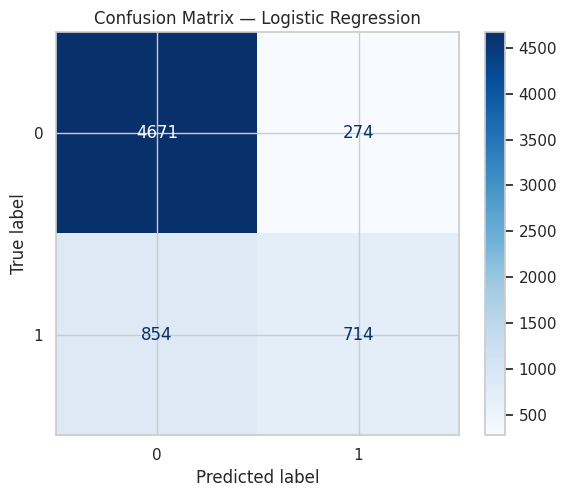

In [ ]:
# Матрица ошибок — видим соотношение TP/FP/TN/FN
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax, cmap="Blues")
ax.set_title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()

### 4.2 Random Forest
> Ансамблевая модель на основе деревьев — лучше ловит нелинейные зависимости.

In [ ]:
# Обучаем Random Forest — ансамбль из 100 деревьев
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average="macro")

print(f"Random Forest — Accuracy: {acc_rf:.4f}, F1-macro: {f1_rf:.4f}")

Random Forest — Accuracy: 0.8578, F1-macro: 0.7936


In [ ]:
# Отчёт по классам для Random Forest
print("Classification Report — Random Forest")
print(classification_report(y_test, y_pred_rf))

Classification Report — Random Forest
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4945
           1       0.74      0.62      0.68      1568

    accuracy                           0.86      6513
   macro avg       0.82      0.78      0.79      6513
weighted avg       0.85      0.86      0.85      6513



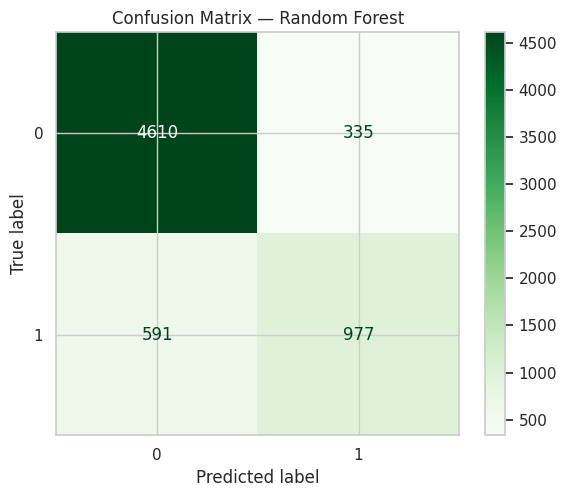

In [ ]:
# Матрица ошибок для Random Forest
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax, cmap="Greens")
ax.set_title("Confusion Matrix — Random Forest")
plt.tight_layout()
plt.show()

### 4.3 Comparison Table
> Сводная таблица — какая модель лучше.

In [ ]:
# Сводная таблица — подсвечиваем лучшие значения
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [acc_lr, acc_rf],
    "F1-macro": [f1_lr, f1_rf],
})

results.style.highlight_max(subset=["Accuracy", "F1-macro"], color="lightgreen")

,Model,Accuracy,F1-macro
0,Logistic Regression,0.826808,0.725475
1,Random Forest,0.857823,0.793602


## Step 5. Experiments
> Эксперименты: подбор гиперпараметров, важность признаков, кросс-валидация.

### 5.1 Hyperparameter Tuning
> Варьируем C (сила регуляризации) для LogReg и max_depth (глубина дерева) для RF.

In [ ]:
# Варьируем C в Logistic Regression (больше C → слабее регуляризация)
c_values = [0.01, 0.1, 1, 10, 100]
lr_results = []

for c in c_values:
    model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    lr_results.append({
        "C": c,
        "Accuracy": accuracy_score(y_test, preds),
        "F1-macro": f1_score(y_test, preds, average="macro"),
    })

lr_exp = pd.DataFrame(lr_results)
print("Logistic Regression — varying C:")
lr_exp

Logistic Regression — varying C:


,C,Accuracy,F1-macro
0,0.01,0.824351,0.717889
1,0.10,0.826654,0.725150
2,1.00,0.826808,0.725475
3,10.00,0.826808,0.725475
4,100.00,0.826961,0.725799


In [ ]:
# Варьируем глубину деревьев в Random Forest (None = без ограничений)
depth_values = [3, 5, 10, 20, None]
rf_results = []

for d in depth_values:
    model = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=42)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    rf_results.append({
        "max_depth": d if d is not None else "None",
        "Accuracy": accuracy_score(y_test, preds),
        "F1-macro": f1_score(y_test, preds, average="macro"),
    })

rf_exp = pd.DataFrame(rf_results)
print("Random Forest — varying max_depth:")
rf_exp

Random Forest — varying max_depth:


,max_depth,Accuracy,F1-macro
0,3,0.815139,0.642053
1,5,0.847996,0.757333
2,10,0.855673,0.775316
3,20,0.859972,0.794878
4,None,0.857823,0.793602


### 5.2 Feature Removal Experiment
> Удаляем каждый признак по одному, чтобы понять, какие наиболее важны для модели.

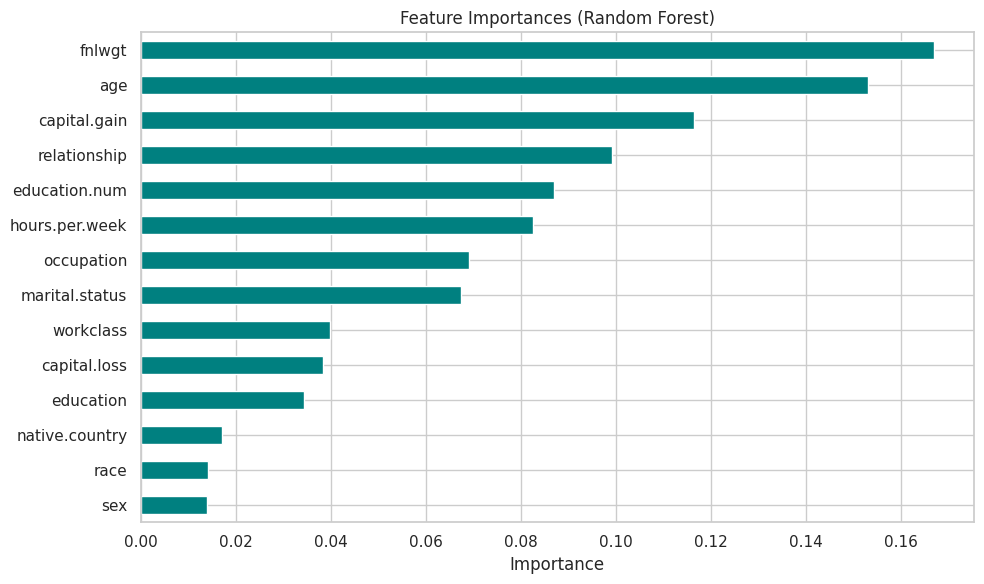

In [ ]:
# Важность признаков по Random Forest (feature_importances_)
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
feat_imp.plot(kind="barh", ax=ax, color="teal")
ax.set_title("Feature Importances (Random Forest)")
ax.set_xlabel("Importance")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Удаляем каждый признак по одному и смотрим, как падает качество
drop_results = []

for col in X.columns:
    X_train_drop = pd.DataFrame(X_train, columns=X.columns).drop(columns=[col])
    X_test_drop = pd.DataFrame(X_test, columns=X.columns).drop(columns=[col])

    sc = StandardScaler()
    X_tr = sc.fit_transform(X_train_drop)
    X_te = sc.transform(X_test_drop)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_tr, y_train)
    preds = model.predict(X_te)

    drop_results.append({
        "Dropped Feature": col,
        "Accuracy": accuracy_score(y_test, preds),
        "F1-macro": f1_score(y_test, preds, average="macro"),
    })

drop_df = pd.DataFrame(drop_results).sort_values("F1-macro", ascending=False)
print(f"Baseline F1-macro (all features): {f1_rf:.4f}")
drop_df

Baseline F1-macro (all features): 0.7936


,Dropped Feature,Accuracy,F1-macro
5,marital.status,0.856441,0.792061
13,native.country,0.856134,0.791513
3,education,0.856134,0.791306
4,education.num,0.857362,0.791001
9,sex,0.854138,0.789402
8,race,0.854598,0.788448
7,relationship,0.854291,0.787469
12,hours.per.week,0.850760,0.784100
1,workclass,0.851067,0.783580
11,capital.loss,0.847843,0.779825


### 5.3 Cross-Validation
> 5-Fold кросс-валидация — проверяем стабильность моделей на разных разбиениях данных.

In [ ]:
# 5-Fold кросс-валидация — более надёжная оценка, чем один train/test split
X_all_scaled = scaler.fit_transform(X)

cv_lr = cross_val_score(LogisticRegression(max_iter=1000, random_state=42),
                        X_all_scaled, y, cv=5, scoring="f1_macro")

cv_rf = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42),
                        X_all_scaled, y, cv=5, scoring="f1_macro")

print("5-Fold Cross-Validation (F1-macro):")
print(f"  Logistic Regression: {cv_lr.mean():.4f} ± {cv_lr.std():.4f}  |  folds: {np.round(cv_lr, 4)}")
print(f"  Random Forest:       {cv_rf.mean():.4f} ± {cv_rf.std():.4f}  |  folds: {np.round(cv_rf, 4)}")

5-Fold Cross-Validation (F1-macro):
  Logistic Regression: 0.6672 ± 0.0684  |  folds: [0.7511 0.7504 0.6125 0.6037 0.6181]
  Random Forest:       0.7012 ± 0.0543  |  folds: [0.735  0.593  0.7216 0.7302 0.7261]


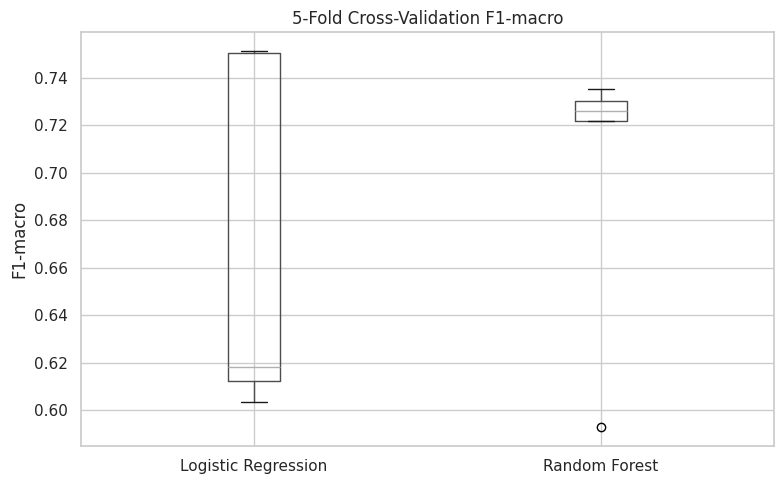

In [ ]:
# Визуализация результатов кросс-валидации
fig, ax = plt.subplots(figsize=(8, 5))
cv_data = pd.DataFrame({
    "Logistic Regression": cv_lr,
    "Random Forest": cv_rf,
})
cv_data.boxplot(ax=ax)
ax.set_title("5-Fold Cross-Validation F1-macro")
ax.set_ylabel("F1-macro")
plt.tight_layout()
plt.show()

## Step 6. Выводы

| Аспект | Результат |
|---|---|
| **Лучшая модель** | Random Forest: Accuracy 0.858, F1-macro 0.794 (vs LogReg: 0.827 / 0.726) |
| **Важные признаки** | `capital.gain`, `age`, `fnlwgt`, `relationship`, `education.num` |
| **Типичные ошибки** | Обе модели чаще пропускают класс >50K (FN > FP) из-за дисбаланса 75/25 |
| **Кросс-валидация** | RF стабильнее: 0.701 ± 0.054 vs LogReg 0.667 ± 0.068 |

### Почему Random Forest лучше?

Связи между признаками и целевой переменной **нелинейные** (слабые корреляции в EDA). Деревья улавливают сложные взаимодействия, которые линейная модель не может.

### Какие ошибки совершает модель?

Больше всего **False Negatives** — модель предсказывает <=50K, хотя реально >50K. RF снизил FN на ~30% по сравнению с LogReg, что и дало рост F1-macro.

### Что можно улучшить?

- Борьба с дисбалансом (SMOTE, class_weight)
- Feature engineering (бинаризовать `capital.gain` > 0)
- Попробовать gradient boosting (XGBoost, LightGBM)